# Liquidity of Pools Related with Bostrom and Space-Pussy

In [1]:
import pandas as pd
import numpy as np
from math import isnan
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from itertools import chain

from src.data_extractors import get_pools, get_prices, get_price_enriched

#### Get Bostrom, Space-Pussy and Osmosis Pools Data

In [2]:
pools_df = get_pools(display_data=False, bostrom_related_osmo_pools=None)
pools_df = \
    pools_df[
        (pools_df.network.isin(['bostrom', 'space-pussy'])) |
        (pools_df.reserve_coin_denoms.map(lambda denoms: 'boot in osmosis' in denoms or 'hydrogen in osmosis' in denoms))]
pools_df

,network,id,type_id,balances,reserve_coin_denoms,swap_fee
0,bostrom,1,1,"[{'denom': 'boot', 'amount': '12146399541121'}...","[boot, hydrogen]",0.0030
1,bostrom,2,1,"[{'denom': 'boot', 'amount': '10987935309'}, {...","[boot, milliampere]",0.0030
2,bostrom,3,1,"[{'denom': 'boot', 'amount': '32159040620'}, {...","[boot, tocyb]",0.0030
3,bostrom,4,1,"[{'denom': 'hydrogen', 'amount': '700056758386...","[hydrogen, tocyb]",0.0030
4,bostrom,5,1,"[{'denom': 'hydrogen', 'amount': '457833670774...","[hydrogen, milliampere]",0.0030
5,bostrom,6,1,"[{'denom': 'hydrogen', 'amount': '414550255671...","[hydrogen, millivolt]",0.0030
6,bostrom,7,1,"[{'denom': 'hydrogen', 'amount': '147660118347...","[hydrogen, uosmo in bostrom]",0.0030
7,bostrom,8,1,[],"[hydrogen, deprecated uatom in bostrom]",0.0030
8,bostrom,9,1,[],"[uosmo in bostrom, deprecated uatom in bostrom]",0.0030
9,bostrom,10,1,"[{'denom': 'milliampere', 'amount': '730569316...","[milliampere, millivolt]",0.0030


#### Calculate Prices

In [3]:
price_df = get_prices(pools_df=pools_df, display_data=True, zero_fee=True)

,aevmos in osmosis,weth.grv in osmosis,ujuno in osmosis,deprecated uatom in bostrom,boot in osmosis,btc in osmosis,dot in osmosis,uosmo in bostrom,hydrogen in osmosis,uflix in osmosis,millivolt,hydrogen,tocyb in osmosis,uatom in bostrom,tocyb,usdt in osmosis,milliampere(pussy),ujuno in bostrom,pussy in bostrom,ugraviton in bostrom,pussy,utia in osmosis,liquidpussy,milliampere,ugraviton in osmosis,udsm in bostrom,reth in osmosis,uion,weth.grv in bostrom,weth in osmosis,aevmos in bostrom,uatom in osmosis,boot,uosmo,liquidpussy in bostrom,sol in osmosis,millivolt(pussy),uatom,ujuno
aevmos in osmosis,1,NaN,NaN,NaN,146399323516.78183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weth.grv in osmosis,NaN,1,NaN,NaN,5804333.734998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ujuno in osmosis,NaN,NaN,1,NaN,0.12233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
deprecated uatom in bostrom,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot in osmosis,0.0,0.0,8.174632,NaN,1,0.036882,0.054305,NaN,0.263123,NaN,NaN,NaN,NaN,NaN,NaN,74.557675,NaN,NaN,NaN,NaN,NaN,1495.436883,NaN,NaN,0.031645,NaN,0.0,27947.731707,NaN,0.0,NaN,745.536477,1,125.655945,NaN,80.75718,NaN,NaN,NaN
btc in osmosis,NaN,NaN,NaN,NaN,27.113166,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dot in osmosis,NaN,NaN,NaN,NaN,18.41456,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.002128,NaN,5.869242,NaN,NaN,NaN,NaN,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
hydrogen in osmosis,NaN,NaN,NaN,NaN,3.800506,NaN,NaN,NaN,1,79.167345,NaN,1,4.249988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,473.459216,NaN,NaN,NaN,NaN,NaN
uflix in osmosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012631,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Prices without References to the Networks

In [4]:
price_enriched_df = get_price_enriched(price_df=price_df, display_data=True)

,aevmos in osmosis,weth.grv in osmosis,ujuno in osmosis,deprecated uatom in bostrom,boot in osmosis,btc in osmosis,dot in osmosis,uosmo in bostrom,hydrogen in osmosis,uflix in osmosis,millivolt,hydrogen,tocyb in osmosis,uatom in bostrom,tocyb,usdt in osmosis,milliampere(pussy),ujuno in bostrom,pussy in bostrom,ugraviton in bostrom,pussy,utia in osmosis,liquidpussy,milliampere,ugraviton in osmosis,udsm in bostrom,reth in osmosis,uion,weth.grv in bostrom,weth in osmosis,aevmos in bostrom,uatom in osmosis,boot,uosmo,liquidpussy in bostrom,sol in osmosis,millivolt(pussy),uatom,ujuno
aevmos in osmosis,1,NaN,NaN,NaN,146399323516.78183,NaN,NaN,NaN,NaN,NaN,NaN,39304199154.637383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146399323516.78183,NaN,NaN,NaN,NaN,NaN,NaN
weth.grv in osmosis,NaN,1,NaN,NaN,5804333.734998,NaN,NaN,NaN,NaN,NaN,NaN,1558304.257152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,5804333.734998,NaN,NaN,NaN,NaN,NaN,NaN
ujuno in osmosis,NaN,NaN,1,NaN,0.12233,NaN,NaN,NaN,0.011857,NaN,NaN,0.011857,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12233,NaN,NaN,NaN,NaN,NaN,1
deprecated uatom in bostrom,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot in osmosis,0.0,0.0,8.174632,NaN,1,0.036882,0.054305,125.655945,0.263123,NaN,19789.87407,0.268473,1.156957,725.291333,1.156957,74.557675,NaN,8.174632,0.000162,NaN,0.000162,1495.436883,NaN,1784.528062,0.031645,NaN,0.0,27947.731707,0.0,0.0,NaN,745.536477,1,125.655945,NaN,80.75718,NaN,745.536477,8.174632
btc in osmosis,NaN,NaN,NaN,NaN,27.113166,1,NaN,NaN,NaN,NaN,NaN,7.279141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.113166,NaN,NaN,NaN,NaN,NaN,NaN
dot in osmosis,NaN,NaN,NaN,NaN,18.41456,NaN,1,NaN,NaN,NaN,NaN,4.943804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.41456,NaN,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,NaN,NaN,NaN,NaN,0.007958,NaN,NaN,1,0.002128,NaN,NaN,0.002128,NaN,5.869242,NaN,NaN,NaN,NaN,0.000003,NaN,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.869242,0.007958,1,NaN,NaN,NaN,5.869242,NaN
hydrogen in osmosis,NaN,NaN,84.340786,NaN,3.800506,NaN,NaN,469.934513,1,79.167345,74245.127956,1,4.249988,2754.836219,4.339732,NaN,NaN,84.340786,0.000607,0.545822,0.000607,NaN,0.000104,6533.868298,NaN,5.880182,NaN,NaN,NaN,NaN,0.0,3.0,3.800506,473.459216,0.000104,NaN,NaN,3.0,84.340786
uflix in osmosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012631,1,NaN,0.012631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Get Pools Liquidity

network,id,reserve_coin_denoms,"liquidity, GH"
space-pussy,1,"[liquidpussy, pussy]",918.8
space-pussy,3,"[liquidpussy, millivolt(pussy)]",173.1
space-pussy,2,"[liquidpussy, milliampere(pussy)]",78.4
space-pussy,4,"[milliampere(pussy), millivolt(pussy)]",29.9
space-pussy,5,"[milliampere(pussy), pussy]",4.4
space-pussy,6,"[millivolt(pussy), pussy]",0.4
osmosis,912,"[weth in osmosis, boot in osmosis]","19,096.2"
osmosis,597,"[boot in osmosis, uosmo]","15,545.2"
osmosis,1326,"[hydrogen in osmosis, boot in osmosis]","11,774.0"
osmosis,1306,"[btc in osmosis, boot in osmosis]","7,535.9"


Total liquidity: 281,166 GH


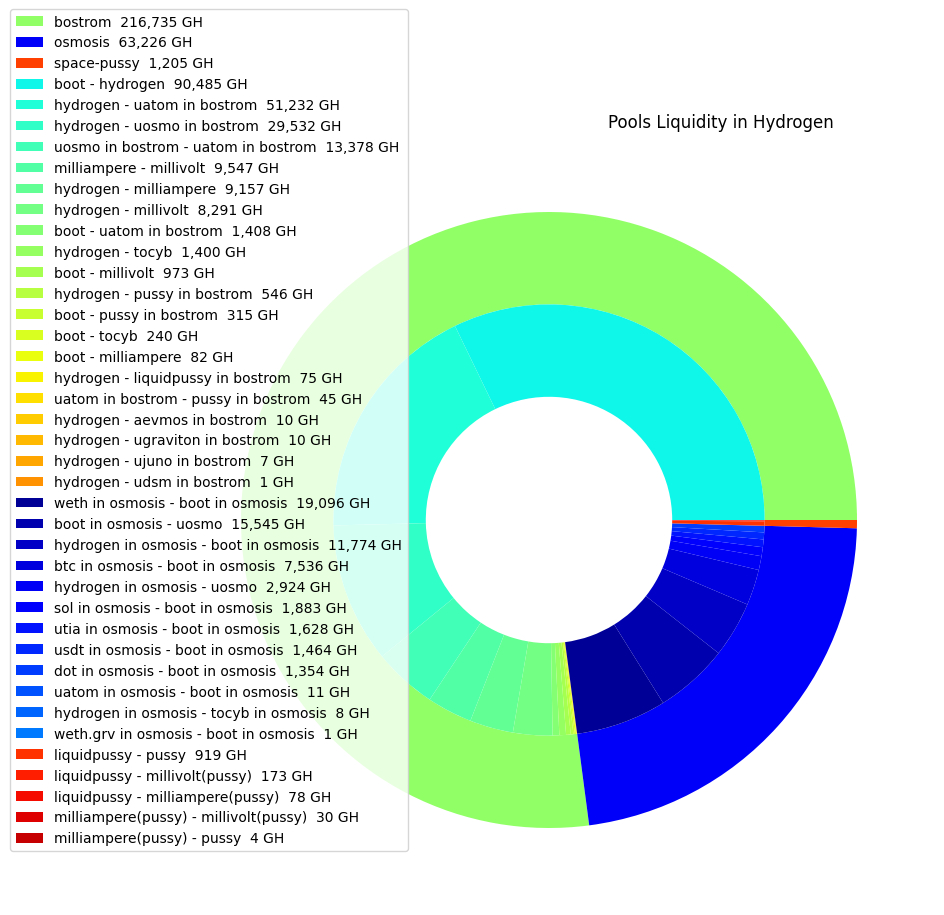

In [5]:
def get_pool_liquidity(balances: list, target_denom: str = 'hydrogen',
                       price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    if not balances:
        return 0
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']: int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    if not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    if not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    return 0


pools_df['liquidity, GH'] = pools_df['balances'].map(get_pool_liquidity) / 1e9
display(HTML(
    pools_df[['network', 'id', 'reserve_coin_denoms', 'liquidity, GH']]
    .sort_values(['network', 'liquidity, GH'], ascending=False)
    .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
    .replace('text-align: left;', 'text-align: right')
    .replace('<tr>', '<tr align="right">')))

print(f"Total liquidity: {round(sum(pools_df['liquidity, GH'])):>,} GH")

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cm2 = plt.get_cmap("jet", 50)
cout = cm(np.array([10, 2, 16]))


pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df.groupby('network')['liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner = pools_df[pools_df['liquidity, GH'] > 1].groupby(
    ['network', 'denoms'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
inner_cnt = inner.groupby('network').count().to_dict()
cin = cm2(np.array(
    list(range(18, 18 + inner_cnt['bostrom'])) + 
    list(range(1, 1 + inner_cnt['osmosis'])) + 
    list(range(42, 42 + inner_cnt['space-pussy']))))
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
ax.pie(inner.values.flatten(),
       radius=1-size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Pools Liquidity in Hydrogen'+' '*19, loc='right')

plt.legend(outer_labels + inner_labels, loc=(-0.2, 0.07))
handles, labels = ax.get_legend_handles_labels()
plt.show()

pools_df.to_csv('data/pools_liquidity.csv')

### Liquidity by Coins

Liquidity by Coins


coin,network,"liquidity, GH"
hydrogen,bostrom,9.537357e+04
boot,bostrom,4.675166e+04
uatom in bostrom,bostrom,3.303139e+04
boot in osmosis,osmosis,3.014672e+04
uosmo in bostrom,bostrom,2.145523e+04
weth in osmosis,osmosis,9.548094e+03
millivolt,bostrom,9.405580e+03
milliampere,bostrom,9.392708e+03
uosmo,osmosis,9.234488e+03
hydrogen in osmosis,osmosis,7.353099e+03


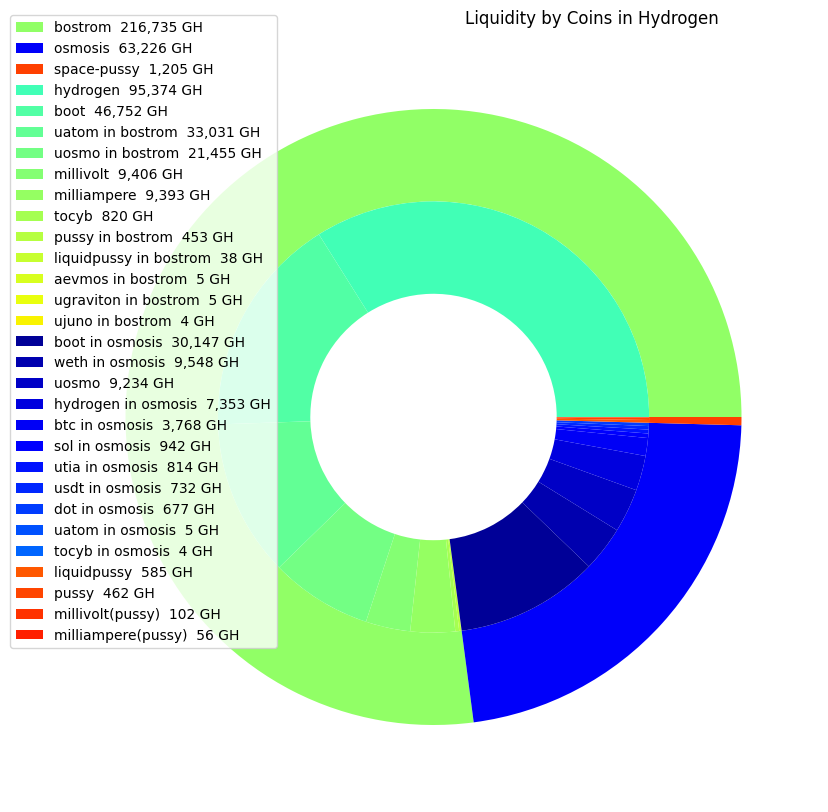

In [6]:
coin_list = set(chain(*pools_df.reserve_coin_denoms.to_list()))
coin_liquidity_data = []
coin_liquidity_df = pd.DataFrame(columns=['coin', 'network', 'liquidity, GH'])
for coin_denom in coin_list:
    pools_liquidity_agg_by_network_df = \
        pools_df[pools_df.reserve_coin_denoms.map(lambda x: coin_denom in x)].groupby('network')['liquidity, GH'].sum() * 0.5
    for network, coin_liquidity in pools_liquidity_agg_by_network_df.items():
        coin_liquidity_data.append({
            'coin': coin_denom,
            'network': network,
            'liquidity, GH': coin_liquidity})
coin_liquidity_df = pd.DataFrame(coin_liquidity_data).sort_values('liquidity, GH', ascending=False).reset_index().drop(columns=['index'])

print('Liquidity by Coins')
display(HTML(
    coin_liquidity_df.to_html(
                index=False, notebook=True, show_dimensions=False)))

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cm2 = plt.get_cmap("jet", 50)
cout = cm(np.array([10, 2, 16]))

outer = coin_liquidity_df.groupby('network')['liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner = coin_liquidity_df[coin_liquidity_df['liquidity, GH'] > 1].groupby(
    ['network', 'coin'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(axis=0, level=[0],
                                                                                             ascending=[True],
                                                                                             inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
inner_cnt = inner.groupby('network').count().to_dict()
cin = cm2(np.array(
    list(range(21, 21 + inner_cnt['bostrom'])) + 
    list(range(1, 1 + inner_cnt['osmosis'])) + 
    list(range(40, 40 + inner_cnt['space-pussy']))))
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
ax.pie(inner.values.flatten(), radius=1 - size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Liquidity by Coins in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(-0.05, 0.2))
handles, labels = ax.get_legend_handles_labels()
plt.show()

coin_liquidity_df.to_csv('data/coins_liquidity.csv')

In [7]:
price_enriched_df.loc['boot']

aevmos in osmosis                       0.0
weth.grv in osmosis                     0.0
ujuno in osmosis                   8.174632
deprecated uatom in bostrom             NaN
boot in osmosis                           1
btc in osmosis                     0.036882
dot in osmosis                     0.054305
uosmo in bostrom                 125.655945
hydrogen in osmosis                0.263123
uflix in osmosis                        NaN
millivolt                       19789.87407
hydrogen                           0.268473
tocyb in osmosis                   1.156957
uatom in bostrom                 725.291333
tocyb                              1.156957
usdt in osmosis                   74.557675
milliampere(pussy)                      NaN
ujuno in bostrom                   8.174632
pussy in bostrom                   0.000162
ugraviton in bostrom                    NaN
pussy                              0.000162
utia in osmosis                 1495.436883
liquidpussy                     